<a href="https://colab.research.google.com/github/mistryvivek/YRKCS-PRBX/blob/main/PADL_Week_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PADL Week 11 Practical: Autoregressive language modelling and zero-shot CLIP

In this practical you will build and train a basic autoregressive language model from scratch and use it to generate new text. You will then use a pretrained vision and language model (CLIP) to do zero-shot classification.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random

We will use a very recurrent neural network to learn a language model. This is a small neural network $y_t,h_t=f(x_t,h_{t-1})$ that takes as input the previous hidden state $h_{t-1}$ and the current input character $x_t$ and outputs the next hidden state $h_t$ and scores for all possible next characters $y_t$.

Start by reading carefully through the notes and code to define and train the model. Ask questions if you don't understand part of it.

The following model can write the works of Shakespeare! (Well, nearly).

In [2]:
class RNN(nn.Module):
    def __init__(self,vocab_size,hidden_size):
        super(RNN, self).__init__()
        self.embedding =  nn.Embedding(vocab_size, hidden_size)
        self.linear_h = nn.Linear(hidden_size,hidden_size)
        self.linear_y = nn.Linear(hidden_size,vocab_size)
        self.tanh = nn.Tanh()

    def forward(self,x,hprev):
        h = self.tanh(self.embedding(x) + self.linear_h(hprev))
        y = self.linear_y(h)
        return h,y

Now we need code to compute a loss to train it. We will provide the model, a sequence of inputs, a sequence of desired outputs (these are just the same as the inputs but lagged by one character), the starting hidden state and the vocabulary size. This code loops over the inputs one character at a time, passing them into the model and updating the hidden state each time. It computes cross entropy loss between the output scores and target labels and returns this along with the final hidden state (which will be used as the initial hidden state for the next sequence).

In [3]:
def calculate_loss(model,inputs,targets,hprev,vocab_size):
  loss_func = nn.CrossEntropyLoss()
  seq_length = len(inputs)
  outputs = torch.zeros(0,vocab_size)
  for t in range(seq_length):
    # For each character in the input sequence, pass through RNN with previous hidden state
    hprev,y = model(torch.tensor([inputs[t]]),hprev)
    # Gradually build up matrix of output logits of size seq_length * vocab_size
    outputs = torch.cat((outputs,y))

  # Compute cross entropy loss for seq_length actual targets against estimated distributions
  loss = loss_func(outputs,torch.tensor(targets))

  # For truncated backprop, the next subsequence will use the final hidden state
  # but will not backprop through it so we need to detach
  hprev = hprev.detach()

  return loss, hprev

Now we need a dataset. Let's use the complete works of William Shakespeare.

In [4]:
!wget https://www-users.york.ac.uk/~waps101/PADL/shakespeare.txt
# You can try the complete Sherlock Holmes later too:
#!wget https://www-users.york.ac.uk/~waps101/PADL/sherlock.txt
data = open('shakespeare.txt', 'r').read() # plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('Data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

--2024-11-07 10:08:42--  https://www-users.york.ac.uk/~waps101/PADL/shakespeare.txt
Resolving www-users.york.ac.uk (www-users.york.ac.uk)... 144.32.129.58, 2001:630:61:180::1:13a
Connecting to www-users.york.ac.uk (www-users.york.ac.uk)|144.32.129.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3801089 (3.6M) [text/plain]
Saving to: ‘shakespeare.txt’

shakespeare.txt     100%[===================>]   3.62M   672KB/s    in 5.7s    

2024-11-07 10:08:48 (647 KB/s) - ‘shakespeare.txt’ saved [3801089/3801089]

Data has 3801089 characters, 66 unique.


Let's define some hyperparameters

In [5]:
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
lr = 0.001
iterations = 5000

Our model is actually quite small

In [6]:
model = RNN(vocab_size,hidden_size)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

23366


We're now ready to train our model. We work our way through the training text, extracting the next subsequence of characters and putting this through the model to get a loss. We don't need to train for long (much less than one epoch) in order to get a reasonable model.

In [7]:
model = RNN(vocab_size,hidden_size)

optim = torch.optim.Adam(model.parameters(), lr = lr)

n, p = 0, 0
while n<=iterations:
  # One iteration of truncated backprop
  if p+seq_length+1 >= len(data) or n==0:
    p=0
    hprev = torch.zeros(hidden_size,) # reset RNN memory
  # Extract next subsequence of characters
  inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
  targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

  # Compute loss for current subsequence
  loss, hprev = calculate_loss(model,inputs,targets,hprev,vocab_size)
  optim.zero_grad()
  loss.backward()
  optim.step()

  if n % 500 == 0:
    print('[{:}] Loss: {:.2f}'.format(n,loss.item()))

  p += seq_length # move data pointer
  n += 1 # iteration counter

[0] Loss: 4.30
[500] Loss: 2.31
[1000] Loss: 2.09
[1500] Loss: 2.50
[2000] Loss: 2.01
[2500] Loss: 1.40
[3000] Loss: 1.66
[3500] Loss: 1.69
[4000] Loss: 1.76
[4500] Loss: 1.55
[5000] Loss: 1.88


Ok, so the loss went down but we don't really know what the model has learnt...

**To do**: create a function to sample from the model (i.e. create random passages of text). The function should take as input:

1. The model itself
2. The previous hidden state (which might be all zeros)
3. A seed initial input (i.e. a random integer between 0 and `vocab_size-1`)
4. The desired sequence length

Your function should pass the current input and previous hidden state to the RNN to get the next hidden state and the output. Apply softmax to the outputs to get probabilities over the vocabulary. Now, randomly sample a character from the distribution (hint: `torch.multinomial` will do this). This provides your next input but should also be appended to the generated output sequence. After generating a sequence of the desired length, return it. Your output should be a list of integers in the range 0 to `vocab_size-1`. The following code shows how it should be called and the output displayed (each time you run it you should get a new random output from the model):

In [10]:
def sample(model,hprev,seed,n):
  ixes = [seed]
  # Start with one seed, get next letter, add that to ixes which goes through the model again and then repeat.
  for t in range(n):
    hprev,y = model(torch.tensor([seed]),hprev)
    probs = nn.functional.softmax(y,dim=1)
    seed = torch.multinomial(probs,1)
    ixes.append(seed.flatten().item())
  return ixes

seed_token = random.randint(0,vocab_size-1)
hprev = torch.zeros(hidden_size,)
sample_ix = sample(model, hprev, seed_token, 200)
txt = ''.join(ix_to_char[ix] for ix in sample_ix)
print('----\n%s \n----' % (txt, ))

----
exven, the ciceds yeimer camy Irans then's thip awss what heis noise as gous stres wordn
Augs aste. When ther.
Brentlius, nom this.

BRUTUS:
I then reseep
And bite; Addidius I haved his go the
I ghee t 
----


You could also modify your training loop to output a random sample every 500 iterations.

**To do**: you can introduce a positive "temperature" parameter to control confidence versus diversity when you take a random sample. To do this, you simply divide the logits output by the model by the temperature before you apply softmax. If the temperature is $>1$, you introduce more randomness. If the temperature is $<1$ you make the model more deterministic. Check this is the case by creating multiple random passages with the same start token and hidden state. Do this for various temperature settings.

###Optional challenge: generating baby names

We will now use a different dataset to generate novel baby names.

Different to the previous exercise, these sequences have an end: the end of the name. So, you will need to increase the vocabulary by one with the last value meaning "end of sequence" (EOS). At each iteration you will process one baby name. You will pass the first character of the name as the initial input and hidden state as all zeroes. The targets will be the name starting from the second character with the extra EOS character index appended to the end. i.e. If the name is "John" then the inputs will be token indices for "John" and the targets will be the token indices for "ohn\<EOS\>".

The model can be trained in exactly the same way. When sampling from the trained model, you do not need to provide a desired sequence length. Instead, you stop when the next character is EOS.

You can download the dataset with one name per line here:

In [ ]:
!wget https://www-users.york.ac.uk/~waps101/PADL/babies.txt

Can your model generate new names that weren't in the training set?

##Zero-shot image classification with CLIP

CLIP is a vision and language model. It uses a Vision transformer to embed images and transformer text encoder to embed captions. The embedding space is shared: if an image and a caption embed to similar vectors then their meaning/contents should be similar. Because it is pretrained on such a large dataset, it can be used as a zero-shot classifier. i.e. you can use it to classify anything you can describe with a caption. You will use it to classify cat versus dog images.

In [11]:
!pip install transformers

In [12]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPTokenizer, CLIPModel
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

In [13]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [15]:
!wget https://www-users.york.ac.uk/~waps101/PADL/cats_and_dogs.zip
!unzip cats_and_dogs.zip

--2024-11-07 10:17:04--  https://www-users.york.ac.uk/~waps101/PADL/cats_and_dogs.zip
Resolving www-users.york.ac.uk (www-users.york.ac.uk)... 144.32.129.58, 2001:630:61:180::1:13a
Connecting to www-users.york.ac.uk (www-users.york.ac.uk)|144.32.129.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71174 (70K) [application/zip]
Saving to: ‘cats_and_dogs.zip.1’

cats_and_dogs.zip.1 100%[===================>]  69.51K   259KB/s    in 0.3s    

2024-11-07 10:17:05 (259 KB/s) - ‘cats_and_dogs.zip.1’ saved [71174/71174]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/00.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cats_and_dogs/00.jpg    
replace cats_and_dogs/01.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cats_and_dogs/01.jpg    
replace cats_and_dogs/03.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: cats_and_dogs/03.jpg    
  inflating: cats_and_dogs/02.jpg    
  inflating: cats_and_dogs/06.jpg    
  inflating: cats_and_do

In [16]:
images = []
for filename in os.listdir('cats_and_dogs'):
  if filename.endswith('.jpg'):
    img = Image.open(os.path.join('cats_and_dogs', filename))
    images.append(img)

You can get the embedding for an image like:

In [18]:
i = 0
image = processor(images=images[i], return_tensors="pt")
image_embedding = model.get_image_features(**image)

You can get the embedding for a text prompt like:

In [19]:
text_input = tokenizer(["A photo of a dog"], padding=True, return_tensors="pt")
text_embedding = model.get_text_features(**text_input)

The two embeddings are PyTorch tensors of shape $1\times 512$. You can pass more than one image or caption at a time and then the first dimension will be the batch size.

Similarity between embeddings is measured by the dot product between their embedding vectors.

**To do**: Can you classify the images as dogs and cats? Display the images along with their classification.

Try some other random images. How discriminative is CLIP? How about the MNIST digits? These are probably quite out-of-domain for its training images.

In [21]:
# My attempt:
for image in images:
  image = processor(images=images[i], return_tensors="pt")
  image_embedding = model.get_image_features(**image)
  print(model(image_embedding, image_embedding))

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 512]

With a CLIP, you must embed your images and outcomes like so:

In [22]:
all_image = processor(images=images, return_tensors="pt")
all_image_embedding = model.get_image_features(**all_image)
all_text_input = tokenizer(["A photo of a cat","A photo of a dog"], padding=True, return_tensors="pt")
all_text_embedding = model.get_text_features(**all_text_input)

torch.Size([10, 2])
tensor([0, 1, 0, 0, 0, 0, 1, 1, 1, 1])


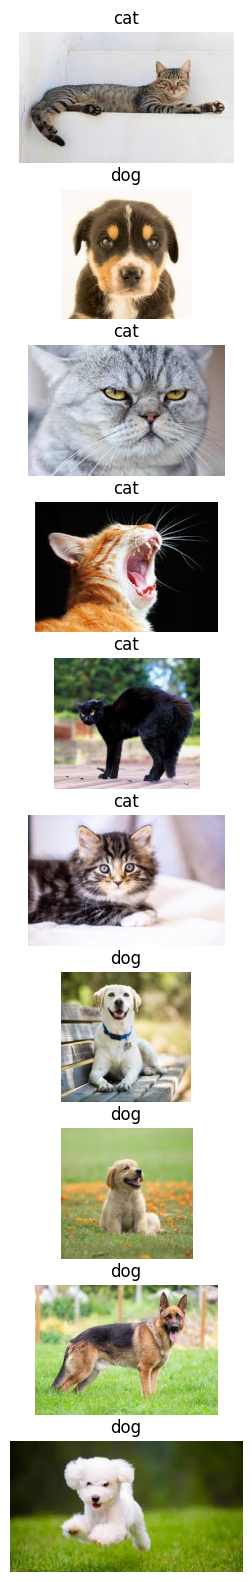

In [23]:
# Formula as described in Wk 11 PADL Lectures.
dot_products = all_image_embedding @ all_text_embedding.T
print(dot_products.shape)
classes = ["cat","dog"]
pred_y = torch.argmax(dot_products, 1)
print(pred_y)

figure = plt.figure(figsize=(20, 20))
for i in range(10):
    figure.add_subplot(10, 1, i+1)
    plt.title(classes[pred_y[i]])
    plt.axis("off")
    plt.imshow(images[i])
plt.show()